# Analysis: Fourier
Peter Sharpe

Running through some fourier-like analyses on S&P500 data.

Note that in these analysis, a "day" represents a trading day, not a calendar day (i.e. markets are closed on weekends).

Imports and data setup:

In [119]:
import numpy as np
import pandas as pd
import os

data = pd.read_csv(
    os.path.abspath("../data/sp_500_max.csv"),
    sep=","
)

daily_change = (
    data["Close"].iloc[1:].values /
    data["Close"].iloc[:-1].values
)
daily_change_pct = (daily_change - 1) * 100


## Statistical Measures

Let's plot a histogram of daily percent change:

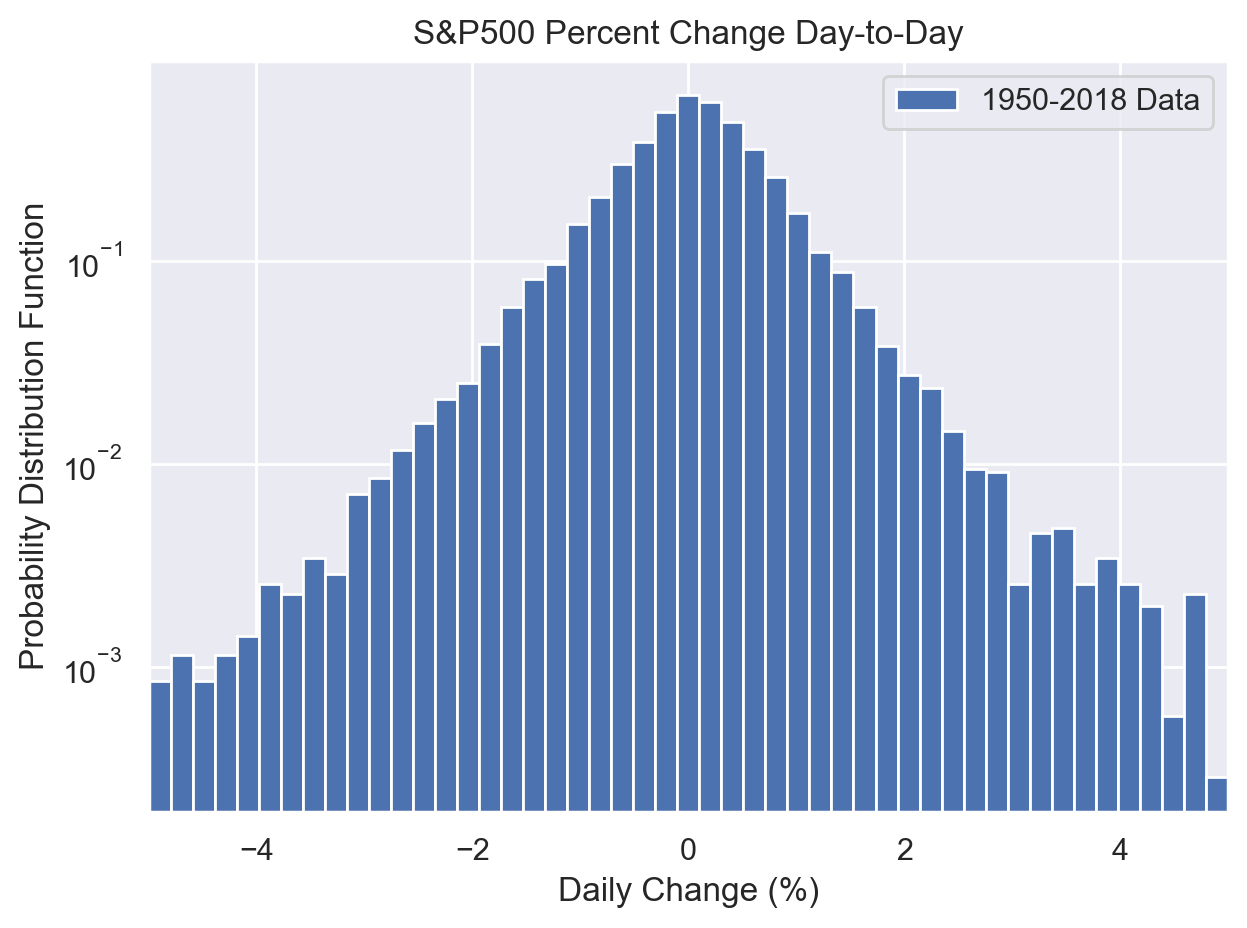

In [120]:
import matplotlib.pyplot as plt
from matplotlib import style
import seaborn as sns
sns.set(font_scale=1)

def make_pct_hist():
    fig, ax = plt.subplots(1, 1, figsize=(6.4, 4.8), dpi=200)
    plt.hist(
        x=daily_change_pct,
        bins=np.linspace(-5, 5, 50),
        density=True,
        label="1950-2018 Data"
    )
def show_pct_hist():
    plt.xlim(-5, 5)
    plt.yscale('log')
    plt.xlabel(r"Daily Change (%)")
    plt.ylabel(r"Probability Distribution Function")
    plt.title(r"S&P500 Percent Change Day-to-Day")
    plt.tight_layout()
    plt.legend()
    # plt.savefig("C:/Users/User/Downloads/temp.svg")
    plt.show()

make_pct_hist()
show_pct_hist()

Huh. This is really interesting, because this doesn't look at all like what a Gaussian distribution looks like on a log scale. Let's fit a Gaussian distribution and plot this with this, too:

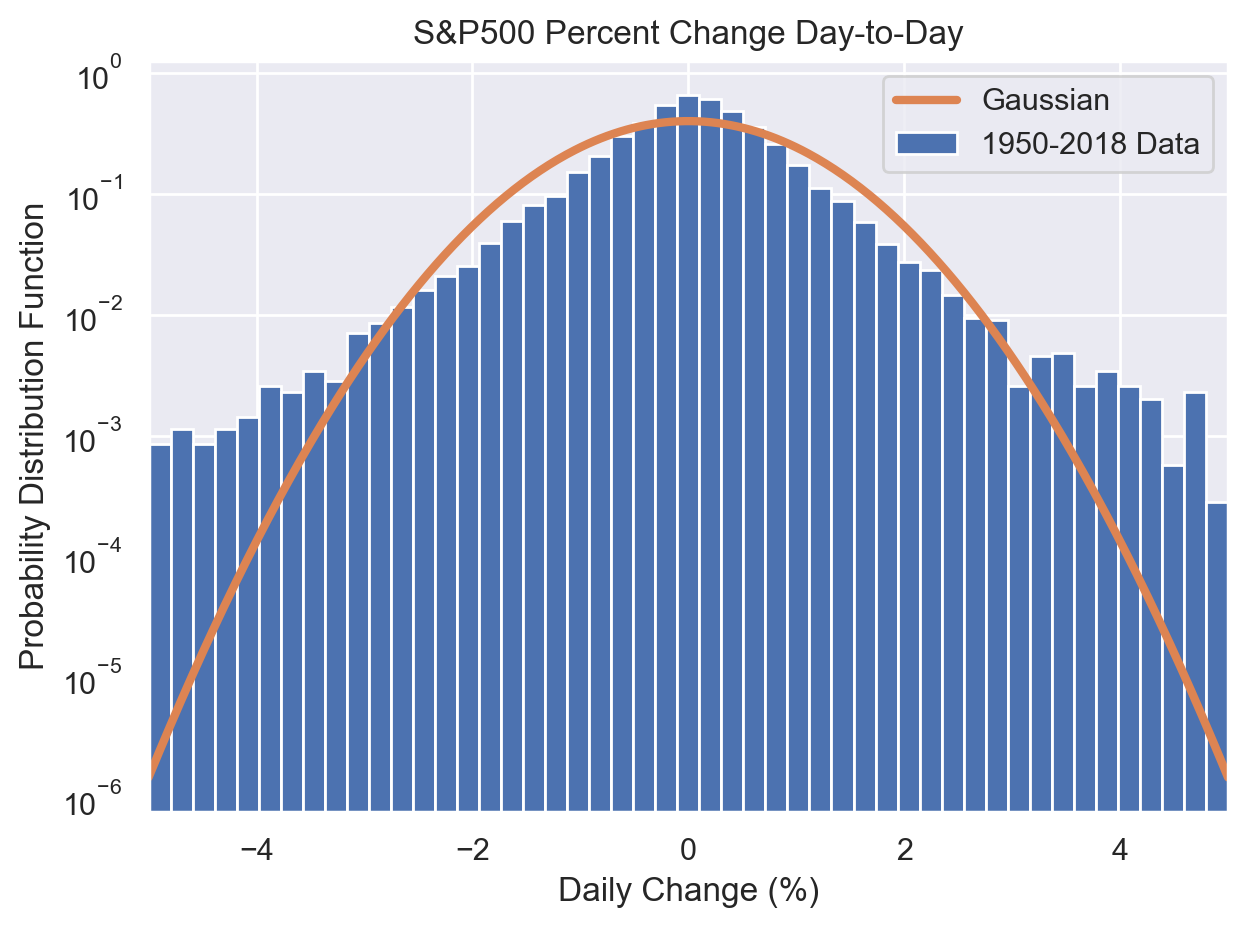

In [121]:
import matplotlib.pyplot as plt
from matplotlib import style
import seaborn as sns
sns.set(font_scale=1)

make_pct_hist()

from scipy import stats
norm_params = stats.norm.fit(data = daily_change_pct)
x = np.linspace(-5, 5, 500)
y = stats.norm.pdf(x=x)
plt.plot(x, y, linewidth=3, label="Gaussian")

show_pct_hist()


We're heavy-tailed! Why is this? If the stock market is truly a random walk in the mathematical sense of the phrase (i.e. Brownian motion), wouldn't the daily change tend towards a Gaussian? So what is the stock market?

## Frequency-Domain
I wanna run two studies next:
1. A Fourier analysis to see what color "noise" we have in the market data
2. An autocorrelation study

### Fourier

Are there patterns in when the stock market tends to go up? Also, what is the character (color) of the noise exhibited by the stock market? Can we use that information to make predictions about the degree to which "momentum" or "correction" typically happens in the market?

No handles with labels found to put in legend.


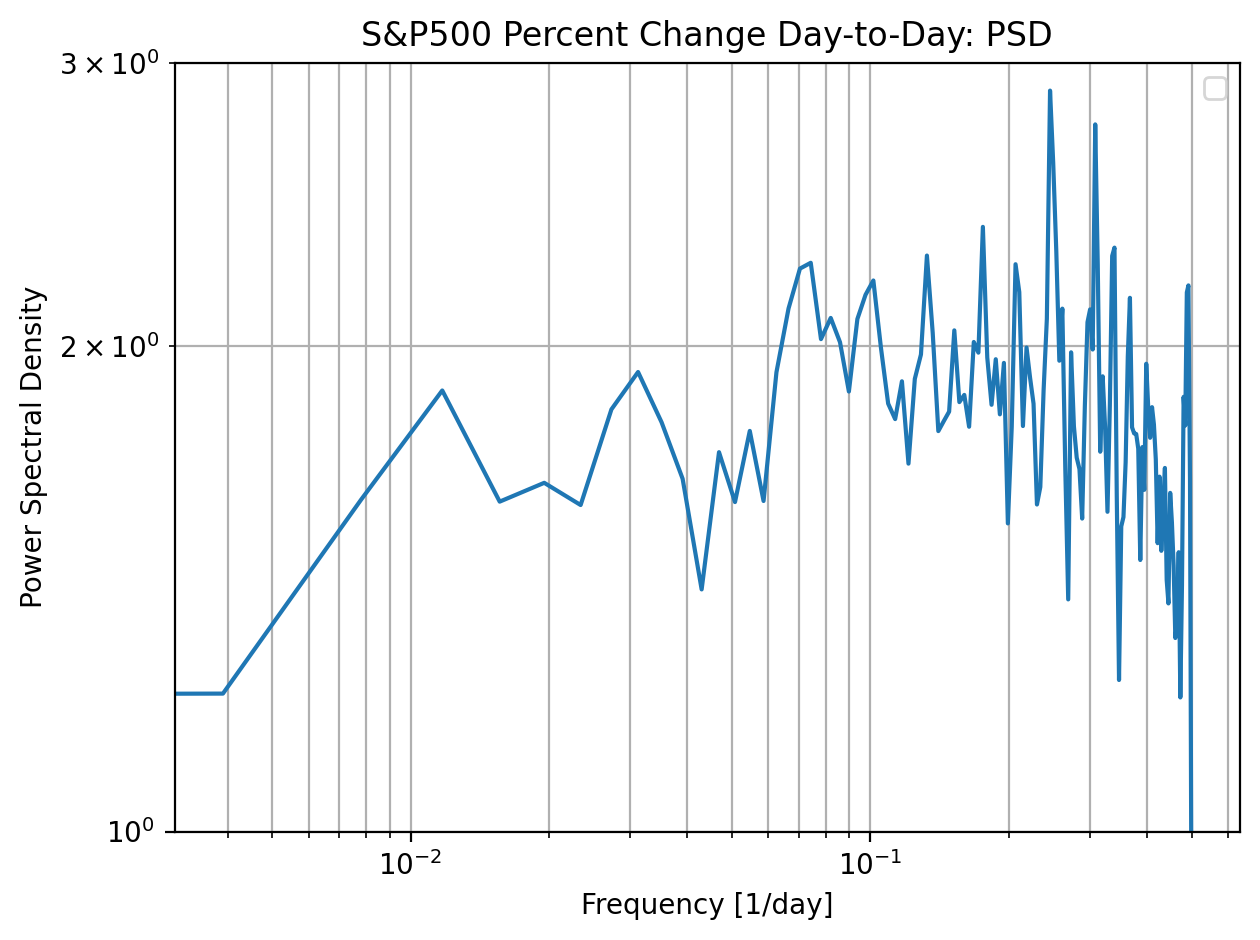

In [122]:
from scipy import signal
freqs, psd = signal.welch(daily_change_pct)
def make_psd():
    fig, ax = plt.subplots(1, 1, figsize=(6.4, 4.8), dpi=200)
    plt.loglog(freqs, psd)

def show_psd():
    plt.grid(True, which='both')
    plt.ylim(1, 3)
    plt.xlabel(r"Frequency [1/day]")
    plt.ylabel(r"Power Spectral Density")
    plt.title(r"S&P500 Percent Change Day-to-Day: PSD")
    plt.tight_layout()
    plt.legend()
    # plt.savefig("C:/Users/User/Downloads/temp.svg")
    plt.show()

with plt.style.context("default"):
    make_psd()
    show_psd()

Well. This was disappointing. We were hoping to find some sort non-white color to the noise here, but it looks pretty flat. Possibilities:
1. The stock market is a random walk
2. We're not looking at high enough frequencies to really see the rolloff

Maybe we can throw a smoothing spline on this PSD data just to see it a bit more clearly?

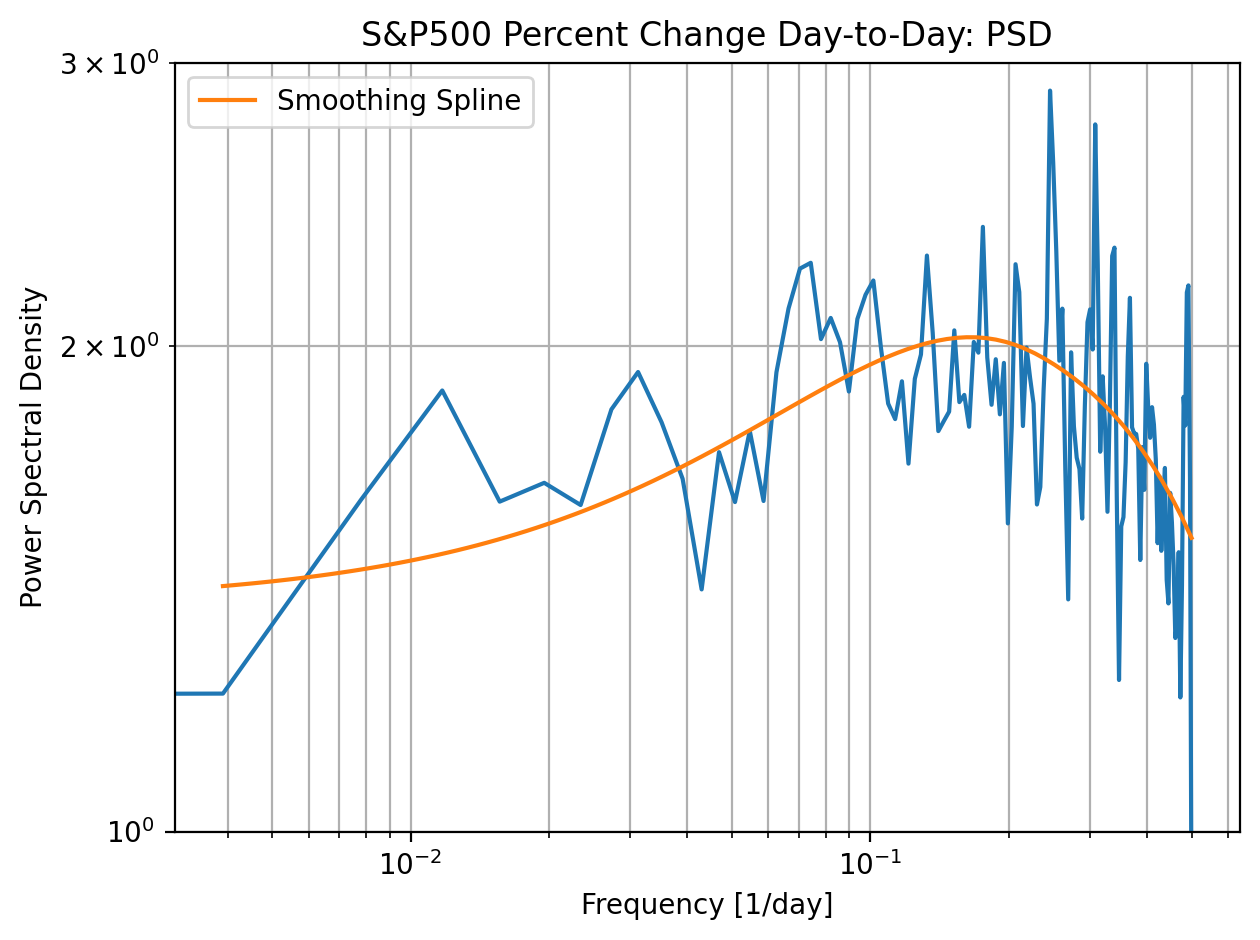

In [123]:
from scipy import interpolate
spline = interpolate.UnivariateSpline(
    x=freqs,
    y=psd,
    s=10,
)
with plt.style.context("default"):
    make_psd()
    freqs_interp = np.logspace(
        np.log10(freqs[1]),
        np.log10(freqs[-1]),
        100
    )
    plt.plot(freqs_interp, spline(freqs_interp), label="Smoothing Spline")
    show_psd()
    

Well, this kinda lends credence to the second theory - maybe the higher frequency stuff really shows this rolloff better? Might be worth grabbing another dataset to see...

### Autocorrelation

"How much does the stock market performance today correlate with the stock market performance $x$ days from now?"

If nonzero; this implies predictive power.

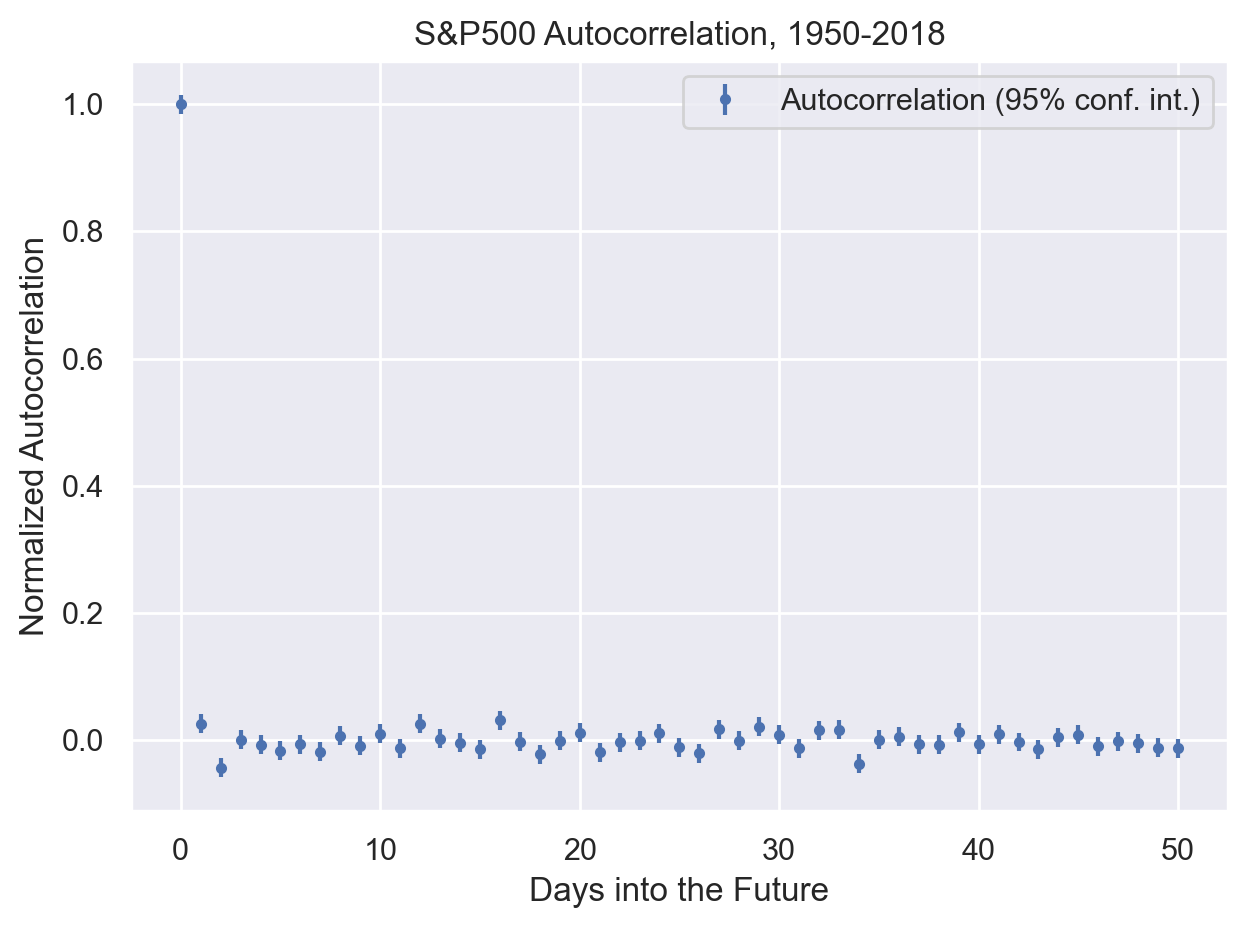

In [124]:
def autocorr(x):
    r2=np.fft.ifft(np.abs(np.fft.fft(x))**2).real
    c=(r2/x.shape-np.mean(x)**2)/np.std(x)**2
    return c[:len(x)//2]

forecast_max_days = 50
autocorr_data=autocorr(daily_change_pct)[:forecast_max_days+1]
autocorr_x=np.arange(len(autocorr_data))

def make_autocorr():
    fig, ax = plt.subplots(1, 1, figsize=(6.4, 4.8), dpi=200)
    plt.errorbar(
        x=autocorr_x,
        y=autocorr_data,
        yerr = 1.96/np.sqrt(len(daily_change_pct)),
        fmt=".",
        label="Autocorrelation (95% conf. int.)"
    )

def show_autocorr():
    plt.xlabel(r"Days into the Future")
    plt.ylabel(r"Normalized Autocorrelation")
    plt.title(r"S&P500 Autocorrelation, 1950-2018")
    plt.tight_layout()
    plt.legend()
    # plt.savefig("C:/Users/User/Downloads/temp.svg")
    plt.show()

make_autocorr()
show_autocorr()

Haha. Well that's not exactly a promising plot!

Honestly, what this says is that the stock market is essentially not self correlated. With that said, it's possible that the autocorrelations on days 2 (slightly positive) and 3 (slightly negative) are not just noise. I wonder what would happen if we implemented a simple trading strategy that reflects this:

1. If the stock market goes up today (Day 0):

    a) Buy first thing in the morning on the next day (Day 1).

    b) Hold for a day, then sell on the next day (Day 2).

2. If the stock market goes down today (Day 0), do the opposite.

But this strategy has several problems:

1. It ignores ask-bid spreads, broker fees, etc. - frequent trading for small gains will erode capital through fees.

2. The general trend of the autocorrelation is generally slightly negative (i.e. the market DOES in fact correct itself). See the following plot:

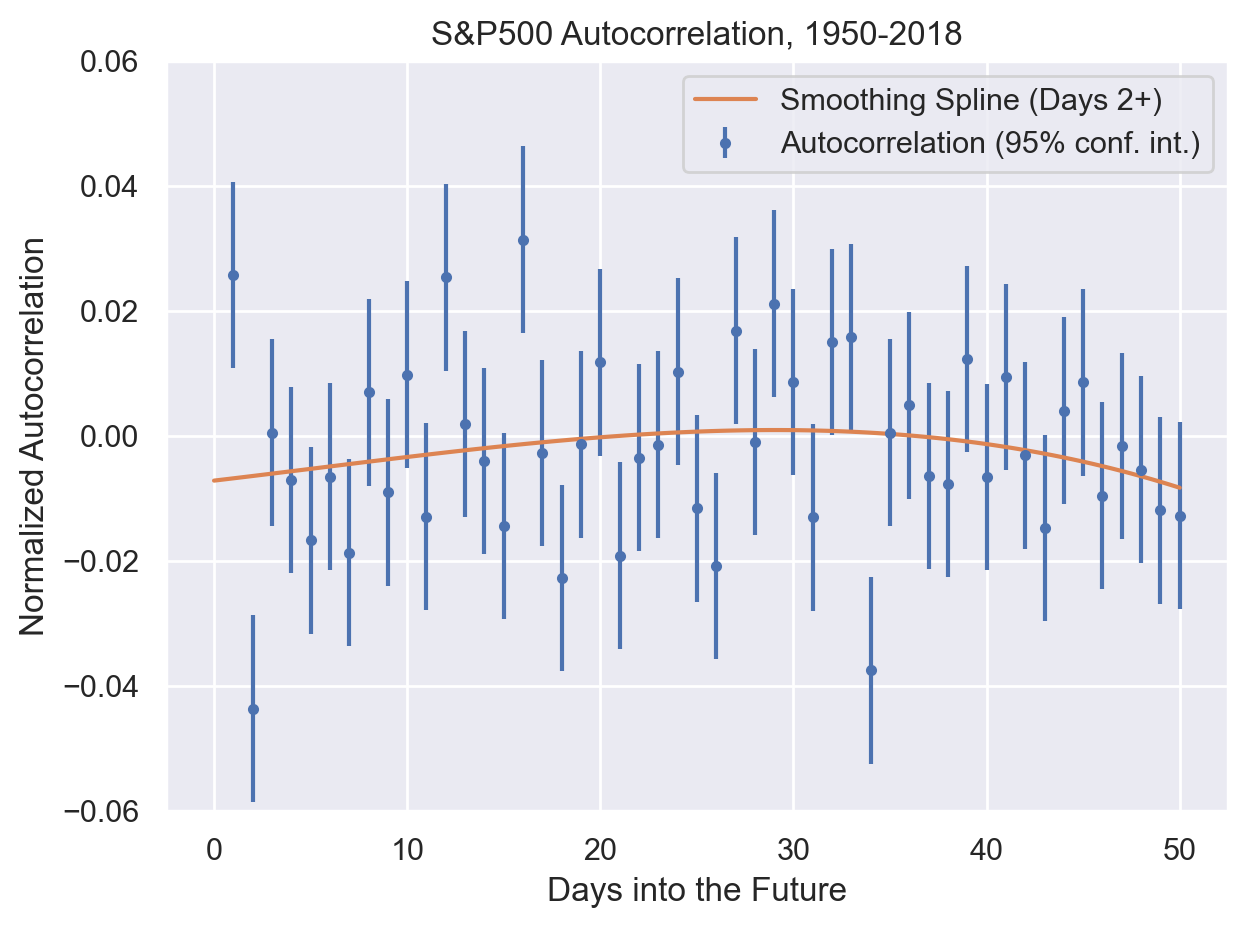

In [125]:
make_autocorr()

spline = interpolate.UnivariateSpline(
    x=autocorr_x[1:],
    y=autocorr_data[1:],
)
x_interp = np.linspace(0,forecast_max_days,100)
plt.plot(
    x_interp,
    spline(x_interp),
    label="Smoothing Spline (Days 2+)"
)
plt.ylim(-0.06, 0.06)
show_autocorr()


This phenomenon might explain why the histogram doesn't follow a Gaussian (which has a theoretical autocorrelation of exactly zero, i.e. each day is independent; white noise).

Cool stuff to think about!